## AIF_sprint10-dnn-scratch
・スクラッチを通してニューラルネットワークの発展的内容を理解する      
・コードをオブジェクト指向で書き換える経験をする


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

### 目的関数（損失関数）

In [2]:
# 平均2乗和誤差
class MeanSquardError:
    def __init__(self):
        pass
    
    def mse(self, y, y_pred):
        # y  :  正解ラベル
        # y_pred  :  予測値
        return np.mean((y - y_pred)**2)/2
        
    
    def backward(self, y, y_pred):
        return y_pred - y

In [3]:
# 交差エントロピー誤差
class CrossEntropyError:
    def __init__(self):
        pass
    
    def cee(self, y_pred, y_train):
        if y_pred.ndim == 1:
            y_train = y_train.reshape(1, y_train.size)
            y_pred = y_pred.reshape(1, y_pred.size)
    
        batch_size = y_pred.shape[0]
        #ミニバッチ単位の損失
        return -np.sum(y_train * np.log(y_pred + 1e-7)) / batch_size

### 活性化関数

In [4]:
# 活性化関数
class ReLU:
    
    def __init__(self):
        #mask
        pass
        
    def forward(self, x):
        return np.maximum(0, x)
    
    def backward(self, x):
        return np.where(x > 0, 1, 0)

In [5]:
# 活性化関数のクラス化
# 活性化関数
class Tanh:
    
    def __init__(self):
        self.forward_A = None
    
    def forward(self, x):
        # backwardの時に必要なのでインスタンス変数として保持
        self.forward_A = x
        return np.tanh(x)
    
    def backward(self, delta):
        # ∂L/∂A2 = ∂L/∂z2 * (1 - tanh(A2)**2)
        #(10, 200) アダマール積 (10, 200) => (10, 200)
        delta = delta * (1 - np.tanh(self.forward_A)**2)
        return  delta


In [6]:
# 出力層の活性化関数
# ソフトマックス関数（MNIST用）
class Softmax:
    def __init__(self):
        self.forward_A = None
        self.y_pred = None
        
    def forward(self,x):
        self.forward_A = x
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            self.y_pred = y.T
        else:
            x = x - np.max(x)
            self.y_pred = np.exp(x) / np.sum(np.exp(x))
        return self.y_pred
    
    def backward(self, delta):
        delta = self.y_pred - delta
        return delta


In [7]:
# 交差エントロピー誤差
class CrossEntropyError:
    def __init__(self):
        pass
    
    def cee(self, y_pred, y_train):
        if y_pred.ndim == 1:
            y_train = y_train.reshape(1, y_train.size)
            y_pred = y_pred.reshape(1, y_pred.size)
    
        batch_size = y_pred.shape[0]
        #ミニバッチ単位の損失
        return -np.sum(y_train * np.log(y_pred + 1e-7)) / batch_size
    
#     def backward(self, y, y_pred):
#         return y_pred - y

### Optimizer（最適化手法のクラス化）

In [8]:
# SGD(Optimizer:最適化手法)のクラス化
class SGD:
    """
    確率的勾配降下法
    lr  :  学習率
    """
    def __init__(self, alpha=0.001):
        self.alpha = alpha
    
    
    """
    ある層の重みやバイアスの更新
    --------------
    layer   :   更新前の層のインスタンス
    layer   :   更新後の層のインスタンス
    """
    def update(self, layer):
        
        layer.W = layer.W - self.alpha * layer.dW / layer.dB.shape[0]
        layer.B = layer.B - self.alpha * layer.dB.mean(axis=0)
        
        return layer

In [9]:
class AdaGrad:
    def __init__():
        self.lr = 0.001
        
    def update():
        pass

### Initializer（初期化）

In [10]:
# 初期方法のクラス化
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma*np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma*np.random.randn(1, n_nodes2)
        return B

### ミニバッチ

In [11]:
class GetMiniBatch():
    """
    ミニバッチを取得するイテレータ
    
    Parameters
    ---------------------
    X　:　学習データ
    y　:　正解値
    batch_size : int
    seed : int　　　NumPyの乱数のシード
    
    ---------------------
    for文で呼び出すと以下の２つを返す
    mini_X  : 学習データのミニバッチ 
    mini_y  : 正解値のミニバッチ
    """
    
    def __init__(self, X, y, batch_size=10, seed=0):
        
        # バッチサイズを指定
        self.batch_size = batch_size
        
        # ランダムに並べ換える
        np.random.seed(seed)
        
        # 48,000行、列？のベクトルが作成される
        # 中身は1から48,000の整数値がランダムにセットされる
        # なるほど、名前からしてそうだね。シャッフルインデックス。。
        #print("testコード", X.shape[0])
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._counter = 0
        
        # イテレーション数を計算する
        # 48,000行/10 = 4,800回となる
        # np.ceilは切り上げする関数
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        # len()が使われたときの処理
        return self._stop
        
    def __iter__(self):
        return self
        
    def __next__(self):
            
        # for文で呼ばれた際のループごとの処理
        if self._counter >= self._stop:
                
            # 最後まで進んだら終了
            self._counter = 0 # カウンターをリセット
            raise StopIteration()
        
        
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
            
        self._counter = self._counter + 1
            
        return self.X[p0:p1], self.y[p0:p1]

### 全結合層

In [12]:
class Full_Connection:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    n_nodes1 :  int
    n_nodes2 :  int
    initializer :  初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    
    # コンストラクタで重みやバイアスの初期化をする
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):

        # 全結合層のコンストラクタに初期化方法のインスタンスを渡したい
        # ノード数を保持する
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.sigma = initializer.sigma
        
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        # 重み・バイアスを初期化
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        #print("doudesuka",n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        #print("★★★★★★★",self.B.shape)
        
        # 引数で受け取ったoptimizer（最適化クラス）をインスタンス変数として持つ
        self.optimizer = optimizer
        
        # ここで初期化が必要。。
        self.X = None
        self.dB = None
        self.dW = None
        self.A = None
        
        # ドロップアウト用
        self.mask = None
        self.dropout_ratio = 0.5
    
    def forward(self, X):
        """
        X  :  配列とシェイプ  （batch_size,  n_nodes1）
        A  :  配列とシェイプ  （batch_size, n_nodes2）
        """
        """
        ドロップアウトする要素（False）としない要素（True）に分ける
        """
        self.X = X.copy()
        self.mask = np.random.rand(*self.X.shape) > self.dropout_ratio
        self.X = self.X * self.mask
        
        # 入力Xをインスタンス変数として保持
        self.X = X.copy()
        
        # 全結合はここで定義している
        self.A = np.dot(self.X, self.W) + self.B
        
        return self.A

    
    def backward(self, dA):
        
        """
        dA  :  後ろから流れてきた勾配(batch_size, n_nodes2)
        dZ  :   前に流す勾配　（batch_size, n_nodes1）
        """
        # バイアスの勾配は、forward時に加算演算なので、
        # 前から受け取った勾配をそもまま利用する
        self.dB = dA
        
        # forward時に活性化関数を通ったXを利用する。Zに相当する
        # 前から受け取ったもdAと、dot積をとる。ひっくり返すところの処理。乗算演算なので
        self.dW = np.dot(self.X.T, dA)
        
        # 後ろに流す勾配
        dZ = np.dot(dA, self.dW.T)
        
        # 引数として自身のインスタンスselfを渡すこともできる
        # 層の重みの更新が可能である
        # self.optimizer.update(self)だけでもOK
        # 各層のbackwardの処理の中で、重みパラメータとバイアスを更新する処理です
        # sprint9の時は最後にまとめて更新していたが、その層の重みとバイアスが求まったタイミングでリアルタイムで更新する
        # また、ここでselfに代入しなくても動作するらしいです。
        #print("fcで最適化する")
        self = self.optimizer.update(self)        
        
        return dZ
    
    def dropout():        
        pass
            

### Trainer

In [13]:
# DNNスクラッチ回帰
class ScratchDeepNeuralNetworkRegressor:
    def __init__(self, n_epochs, batch_size, lr, sigma, n_nodes1, n_nodes2, n_output):
        self.n_epochs    =  n_epochs    # エポック数
        self.batch_size  = batch_size   #バッチサイズ
        self.lr                  =  lr                   # 学習率
        self.sigma          =  sigma            # シグマ
        self.n_nodes1   =  n_nodes1    # 1層目のノード数
        self.n_nodes2   =  n_nodes2    # 2層目のノード数
        self.n_output    = n_output      # 出力層のノード数
        self.loss             =  None
        self.val_loss     =  None
        
        self.loss_list = []
        self.epoch_loss_list = []
        
        #　入力層の特徴量（今回は2種類）
        # fitの中でインスタンス変数を定義するためには、ここで事前に定義する必要がある
        self.n_features = None
        
        self.fc1 = None
        self.fc2 = None
        self.fc3 = None
        
        self.activation1 = None
        self.activation2 = None
        self.activation3 = None
        
        self.tomo = None
    
    def fit(self, X, y, X_val=None, y_val=None):

        #print("testコード0---", y.shape)
        #y = y[:, np.newaxis]
        #print("testコード0---", y.shape)        
        
        # ミニバッチ単位で処理する
        train_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=0)
        #test_batch = GetMiniBatch(X_val, y_val, batch_size=self.batch_size, seed=0)
        
        #print("testコード01---", y_val.shape)
        #y_val = y_val[:, np.newaxis]
        #print("testコード01---", y_val.shape)
        
        # 最適化関数（オプティマイザー）クラスをインスタンス化する
        optimizer = SGD(self.lr)

        # fitを呼び出す時に、ここで特徴量を把握すれば、コンストラクタでわざわざ定義しなくても良い
        self.n_features = X.shape[1]        

        # インスタンス化（開始） ########################################
        # for文の外でインスタンス化しないと、いけないはず
        # for文の中でインスタンス化してしまうと、ループで毎回初期化されて、
        # backwardでforward時のA(=X・W+B)を使えなくなってしまうから
        
        # 1層目
        # 全結合層クラスをインスタンス化する
        # SimpleInitializerを引数の中でクラスを呼んでいる理由は、各層で異なる初期値を与えて上げることができるため
        # optimizerを全結合で
        self.fc1 = Full_Connection(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        # 活性化関数クラスをインスタンス化する
        self.activation1 = Tanh()
        #self.activation1 = ReLU()
        
        
        # 2層目
        # 全結合層クラスをインスタンス化する
        self.fc2 = Full_Connection(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        # 活性化関数クラスをインスタンス化する
        self.activation2 = Tanh()
        #self.activation2 = ReLU()
        
        # 3層目
        # 全結合層クラスをインスタンス化する
        self.fc3 = Full_Connection(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        
        # 平均二乗誤差クラスをインスタンス化する
        self.activation3 = MeanSquardError()
        # インスタンス化（終了） ########################################
        
                
        # エポック単位のループ
        for epoch in range(self.n_epochs):
                       
            # ミニバッチ単位のループ
            #a = 0
            for mini_X_train, mini_y_train in train_batch:      
                #a = a +1
                # フォワード ########################################
                # 1層目
                # 全結合層（A = X・W + B）
                #print("testcode1",mini_X_train.shape)
                A1 = self.fc1.forward(mini_X_train)
                # 活性化関数（Z = 活性化関数（A））
                Z1 = self.activation1.forward(A1)

                # 2層目
                # 全結合層（A = Z・W + B）
                A2 = self.fc2.forward(Z1)
                # 活性化関数（Z = 活性化関数（A））
                Z2 = self.activation2.forward(A2)

                # 3層目
                # 全結合層（A = Z・W + B）
                A3 = self.fc3.forward(Z2)
                # 活性化関数（Z = 活性化関数（A））　　・・・回帰の時は恒等関数
                Z3 = A3
                
                self.loss = self.activation3.mse(mini_y_train, Z3)
                self.loss_list.append(self.loss)

                # バックワード ########################################
                # 3層目
                # 平均2乗誤差のバックワード
                dA3 = self.activation3.backward(mini_y_train, Z3)
                # 全結合層のバックワード
                dZ2 = self.fc3.backward(dA3)

                # 2層目
                # 活性化関数のバックワード
                dA2 = self.activation2.backward(dZ2)
                # 全結合層のバックワード
                dZ1 = self.fc2.backward(dA2)

                # 1層目
                # 活性化関数のバックワード
                dA1 = self.activation1.backward(dZ1)
                # 全結合層のバックワード
                dZ0 = self.fc1.backward(dA1)
            
            #print(a)
            self.epoch_loss_list.append(self.loss)
    
    def predict(self, X):
        
        # 1層目  ############################################
        A1 = self.fc1.forward(X)
        # この時点ではOK
        #print(A1.shape) # (292, 500)
        #print(A1) # バラバラな値である
        self.tomo = A1
        
        Z1 = self.activation1.forward(A1)
        #print(Z1.shape) # (292, 500)
        #print(Z1)

        # 2層目  ############################################
        A2 = self.fc2.forward(Z1)
        #print(A2.shape)
        #print(A2)
        
        Z2 = self.activation2.forward(A2)
        #print("Z2.shape : ",Z2.shape)
        #print(Z2)
        #print(np.unique(Z2))

        # 3層目  ############################################
        A3 = self.fc3.forward(Z2)
        #print(A3.shape)
        Z3 = A3
        
        return Z3

In [14]:
import pandas as pd

data = pd.read_csv("/Users/andoutakaaki/DIC_study/sprint10/train.csv")
X = data[["GrLivArea", "YearBuilt"]].values
y = data["SalePrice"].values

#print(X.shape)
y = y[:, np.newaxis]
# 正規化
X = np.log(X)
y = np.log(y)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

from  sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 2) (292, 2) (1168, 1) (292, 1)


### インスタンス生成

In [15]:
sdnnr1 = ScratchDeepNeuralNetworkRegressor(n_epochs=1000, batch_size=50, lr=0.0001,sigma=0.01, n_nodes1=3, n_nodes2=2, n_output=1)
sdnnr1.fit(X_train, y_train)

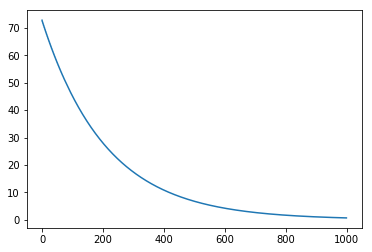

In [16]:
# エポック毎の損失値
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(sdnnr1.epoch_loss_list)
plt.show()

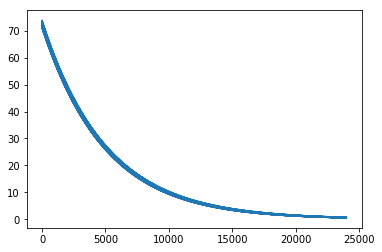

In [17]:
# ミニバッチ毎の損失値
plt.plot(sdnnr1.loss_list)
plt.show()

### 評価

In [18]:
y_pred1 = sdnnr1.predict(X_test)

In [19]:
y_pred1[0:10]

array([[10.93732035],
       [10.93732035],
       [10.93732035],
       [10.93732035],
       [10.93732035],
       [10.93732035],
       [10.93732035],
       [10.93732035],
       [10.93732035],
       [10.93732035]])

In [20]:
m = MeanSquardError()
m.mse(y_test, y_pred1)

0.6553843111436706

### 説明課題

#### ドロップアウトとは何か
ニューラルネットワークは過学習が発生しやすく、その解決方法として提案されたのがドロップアウトである。ドロップアウトは、学習中に中間層のユニットの値を一定の割合で0にし、結合を欠落させることで、ネットワークの締め付けを行って、過学習を抑制する。

#### 近年ReLUが一般的に使われている理由
ディープラーニングではモデルのパラメータを学習するために、誤差伝搬法という方法を繰り返し用いている。モデルから出力されたデータと解答を照らし合わせて,
誤差を求めるが, その際、前回の誤差との差分に注目する。この時、誤差に微分値を使うが、ReLUを使うと、この微分は入力値が正の値であれば１を返し、誤差の微分を０にすることなく、次の学習へつなげることができる。

#### 重みの初期化方法について
学習時、ネットワークのパラメータは乱数で初期化する。非常に深いネットワークの場合、初期化した乱数の値によってはバッチ正規化などのテクニックを利用しても収束しないことがある。学習をスムーズに進めるためには、単に乱数で初期化するのではなく、ある条件下において乱数で初期化することが大切である。   
Xavierの初期化は、層のユニット数によって乱数の範囲を決める。Heの初期化は、活性化関数にReLUを用いることを想定し、各層におけるユニット数によって乱数の範囲を決める。

#### 代表的な最適化手法について
・SGD（Stochastic Gradient Descent；確率的勾配降下法）：ミニバッチや逐次学習のように、学習サンプルの一部を用いて更新量を求める手法      
・慣性項（モーメンタム）：前回の更新における勾配を反映させて勾配の振動を抑制し、収束性を改善する手法       
・AdaGrad：学習におけるパラメータを更新するかを決めるハイパーパラメータである学習係数を自動で調整することができる手法    
・Adam：過去の勾配の移動平均、過去の勾配の二乗の移動平均の両方を用いて、その偏りを補正した推定値を計算することによって、移動平均を用いたバイアスを打ち消すことができ、更新量の偏りを小さくする手法